# Demo code for "[Similarity of Neural Network Representations Revisited](https://arxiv.org/abs/1905.00414)"

Copyright 2019 Google LLC

Licensed under the Apache License, Version 2.0 (the "License");
you may not use this file except in compliance with the License.
You may obtain a copy of the License at

    https://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS,
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
See the License for the specific language governing permissions and
limitations under the License.

Please cite as:

    @inproceedings{pmlr-v97-kornblith19a,
      title = {Similarity of Neural Network Representations Revisited},
      author = {Kornblith, Simon and Norouzi, Mohammad and Lee, Honglak and Hinton, Geoffrey},
      booktitle = {Proceedings of the 36th International Conference on Machine Learning},
      pages = {3519--3529},
      year = {2019},
      volume = {97},
      month = {09--15 Jun},
      publisher = {PMLR}
    }

In [1]:
import numpy as np

def gram_linear(x):
  """Compute Gram (kernel) matrix for a linear kernel.

  Args:
    x: A num_examples x num_features matrix of features.

  Returns:
    A num_examples x num_examples Gram matrix of examples.
  """
  return x.dot(x.T)


def gram_rbf(x, threshold=1.0):
  """Compute Gram (kernel) matrix for an RBF kernel.

  Args:
    x: A num_examples x num_features matrix of features.
    threshold: Fraction of median Euclidean distance to use as RBF kernel
      bandwidth. (This is the heuristic we use in the paper. There are other
      possible ways to set the bandwidth; we didn't try them.)

  Returns:
    A num_examples x num_examples Gram matrix of examples.
  """
  dot_products = x.dot(x.T)
  sq_norms = np.diag(dot_products)
  sq_distances = -2 * dot_products + sq_norms[:, None] + sq_norms[None, :]
  sq_median_distance = np.median(sq_distances)
  return np.exp(-sq_distances / (2 * threshold ** 2 * sq_median_distance))


def center_gram(gram, unbiased=False):
  """Center a symmetric Gram matrix.

  This is equvialent to centering the (possibly infinite-dimensional) features
  induced by the kernel before computing the Gram matrix.

  Args:
    gram: A num_examples x num_examples symmetric matrix.
    unbiased: Whether to adjust the Gram matrix in order to compute an unbiased
      estimate of HSIC. Note that this estimator may be negative.

  Returns:
    A symmetric matrix with centered columns and rows.
  """
  if not np.allclose(gram, gram.T):
    raise ValueError('Input must be a symmetric matrix.')
  gram = gram.copy()

  if unbiased:
    # This formulation of the U-statistic, from Szekely, G. J., & Rizzo, M.
    # L. (2014). Partial distance correlation with methods for dissimilarities.
    # The Annals of Statistics, 42(6), 2382-2412, seems to be more numerically
    # stable than the alternative from Song et al. (2007).
    n = gram.shape[0]
    np.fill_diagonal(gram, 0)
    means = np.sum(gram, 0, dtype=np.float64) / (n - 2)
    means -= np.sum(means) / (2 * (n - 1))
    gram -= means[:, None]
    gram -= means[None, :]
    np.fill_diagonal(gram, 0)
  else:
    means = np.mean(gram, 0, dtype=np.float64)
    means -= np.mean(means) / 2
    gram -= means[:, None]
    gram -= means[None, :]

  return gram


def cka(gram_x, gram_y, debiased=False):
  """Compute CKA.

  Args:
    gram_x: A num_examples x num_examples Gram matrix.
    gram_y: A num_examples x num_examples Gram matrix.
    debiased: Use unbiased estimator of HSIC. CKA may still be biased.

  Returns:
    The value of CKA between X and Y.
  """
  gram_x = center_gram(gram_x, unbiased=debiased)
  gram_y = center_gram(gram_y, unbiased=debiased)

  # Note: To obtain HSIC, this should be divided by (n-1)**2 (biased variant) or
  # n*(n-3) (unbiased variant), but this cancels for CKA.
  scaled_hsic = gram_x.ravel().dot(gram_y.ravel())

  normalization_x = np.linalg.norm(gram_x)
  normalization_y = np.linalg.norm(gram_y)
  return scaled_hsic / (normalization_x * normalization_y)


def _debiased_dot_product_similarity_helper(
    xty, sum_squared_rows_x, sum_squared_rows_y, squared_norm_x, squared_norm_y,
    n):
  """Helper for computing debiased dot product similarity (i.e. linear HSIC)."""
  # This formula can be derived by manipulating the unbiased estimator from
  # Song et al. (2007).
  return (
      xty - n / (n - 2.) * sum_squared_rows_x.dot(sum_squared_rows_y)
      + squared_norm_x * squared_norm_y / ((n - 1) * (n - 2)))


def feature_space_linear_cka(features_x, features_y, debiased=False):
  """Compute CKA with a linear kernel, in feature space.

  This is typically faster than computing the Gram matrix when there are fewer
  features than examples.

  Args:
    features_x: A num_examples x num_features matrix of features.
    features_y: A num_examples x num_features matrix of features.
    debiased: Use unbiased estimator of dot product similarity. CKA may still be
      biased. Note that this estimator may be negative.

  Returns:
    The value of CKA between X and Y.
  """
  features_x = features_x - np.mean(features_x, 0, keepdims=True)
  features_y = features_y - np.mean(features_y, 0, keepdims=True)

  dot_product_similarity = np.linalg.norm(features_x.T.dot(features_y)) ** 2
  normalization_x = np.linalg.norm(features_x.T.dot(features_x))
  normalization_y = np.linalg.norm(features_y.T.dot(features_y))

  if debiased:
    n = features_x.shape[0]
    # Equivalent to np.sum(features_x ** 2, 1) but avoids an intermediate array.
    sum_squared_rows_x = np.einsum('ij,ij->i', features_x, features_x)
    sum_squared_rows_y = np.einsum('ij,ij->i', features_y, features_y)
    squared_norm_x = np.sum(sum_squared_rows_x)
    squared_norm_y = np.sum(sum_squared_rows_y)

    dot_product_similarity = _debiased_dot_product_similarity_helper(
        dot_product_similarity, sum_squared_rows_x, sum_squared_rows_y,
        squared_norm_x, squared_norm_y, n)
    normalization_x = np.sqrt(_debiased_dot_product_similarity_helper(
        normalization_x ** 2, sum_squared_rows_x, sum_squared_rows_x,
        squared_norm_x, squared_norm_x, n))
    normalization_y = np.sqrt(_debiased_dot_product_similarity_helper(
        normalization_y ** 2, sum_squared_rows_y, sum_squared_rows_y,
        squared_norm_y, squared_norm_y, n))

  return dot_product_similarity / (normalization_x * normalization_y)

## Tutorial

First, we generate some random data.

In [2]:
np.random.seed(1337)
X = np.random.randn(100, 10)
Y = np.random.randn(100, 10) + X

Linear CKA can be computed either based on dot products between examples or dot products between features:
$$\langle\text{vec}(XX^\text{T}),\text{vec}(YY^\text{T})\rangle = ||Y^\text{T}X||_\text{F}^2$$
The formulation based on similarities between features (right-hand side) is faster than the formulation based on similarities between similarities between examples (left-hand side) when the number of examples exceeds the number of features. We provide both formulations here and demonstrate that they are equvialent.

In [3]:
cka_from_examples = cka(gram_linear(X), gram_linear(Y))
cka_from_features = feature_space_linear_cka(X, Y)

print('Linear CKA from Examples: {:.5f}'.format(cka_from_examples))
print('Linear CKA from Features: {:.5f}'.format(cka_from_features))
np.testing.assert_almost_equal(cka_from_examples, cka_from_features)

Linear CKA from Examples: 0.55761
Linear CKA from Features: 0.55761


It is also possible to compute CKA with nonlinear kernels. Here, we use an RBF kernel with the bandwidth set to $\frac{1}{2}$ the median distance in the distance matrix.

In [4]:
rbf_cka = cka(gram_rbf(X, 0.5), gram_rbf(Y, 0.5))
print('RBF CKA: {:.5f}'.format(rbf_cka))

RBF CKA: 0.65483


If the number of examples is small, it might help to compute a "debiased" form of CKA. This form of CKA can be obtained by recognizing that HSIC can be formulated as a U-statistic, as in [Song et al., 2007](https://arxiv.org/pdf/0704.2668.pdf), and replacing biased estimators of HSIC in the numerator and denominator with this unbiased estimator. With some further algebraic manipulation, we also derived an unbiased estimator based on similarities between features rather than the Gram matrices. The resulting estimator of CKA is still generally biased, but the bias is reduced.

In [5]:
cka_from_examples_debiased = cka(gram_linear(X), gram_linear(Y), debiased=True)
cka_from_features_debiased = feature_space_linear_cka(X, Y, debiased=True)

print('Linear CKA from Examples (Debiased): {:.5f}'.format(
    cka_from_examples_debiased))
print('Linear CKA from Features (Debiased): {:.5f}'.format(
    cka_from_features_debiased))

np.testing.assert_almost_equal(cka_from_examples_debiased,
                               cka_from_features_debiased)

Linear CKA from Examples (Debiased): 0.51346
Linear CKA from Features (Debiased): 0.51346


## CKA vs. CCA

Below, we show how to compute the mean squared CCA correlation $R^2_\text{CCA}$.

In [6]:
def cca(features_x, features_y):
  """Compute the mean squared CCA correlation (R^2_{CCA}).

  Args:
    features_x: A num_examples x num_features matrix of features.
    features_y: A num_examples x num_features matrix of features.

  Returns:
    The mean squared CCA correlations between X and Y.
  """
  qx, _ = np.linalg.qr(features_x)  # Or use SVD with full_matrices=False.
  qy, _ = np.linalg.qr(features_y)
  return np.linalg.norm(qx.T.dot(qy)) ** 2 / min(
      features_x.shape[1], features_y.shape[1])

print('Mean Squared CCA Correlation: {:.5f}'.format(cca(X, Y)))

Mean Squared CCA Correlation: 0.54312


## Invariance Properties

Finally, we verify the invariance properties of CKA and compare them to CCA.

In [7]:
transform = np.random.randn(10, 10)
_, orthogonal_transform = np.linalg.eigh(transform.T.dot(transform))

# CKA is invariant only to orthogonal transformations.
np.testing.assert_almost_equal(
    feature_space_linear_cka(X, Y),
    feature_space_linear_cka(X.dot(orthogonal_transform), Y))
np.testing.assert_(not np.isclose(
    feature_space_linear_cka(X, Y),
    feature_space_linear_cka(X.dot(transform), Y)))

# CCA is invariant to any invertible linear transform.
np.testing.assert_almost_equal(cca(X, Y), cca(X.dot(orthogonal_transform), Y))
np.testing.assert_almost_equal(cca(X, Y), cca(X.dot(transform), Y))

# Both CCA and CKA are invariant to isotropic scaling.
np.testing.assert_almost_equal(cca(X, Y), cca(X * 1.337, Y))
np.testing.assert_almost_equal(
    feature_space_linear_cka(X, Y),
    feature_space_linear_cka(X * 1.337, Y))

In [8]:
import os
import random

#weights_path = '/media/gabriel/BA1041B410417881/Users/gabrielc/Projects/mae/output_only_imagenet/ft/base/checkpoint.pth'
weights_path = '/media/gabriel/BA1041B410417881/Users/gabrielc/Projects/mae/output_epochs/ft/base/2000/checkpoint.pth'
images = ['/home/gabriel/Downloads/selected_castasv6_xai/20230602,iPhone_14,IMG_2151.jpg',
 '/home/gabriel/Downloads/selected_castasv6_xai/20230519,iPhone_14,IMG_0970.jpg',
 '/home/gabriel/Downloads/selected_castasv6_xai/20230602,iPhone_14,IMG_2320.jpg',
 '/home/gabriel/Downloads/selected_castasv6_xai/20230630,Canon_EOS_Rebel_T100,IMG_5625.jpg',
 '/home/gabriel/Downloads/selected_castasv6_xai/20230630,iPhone_14,IMG_6043.jpg',
 '/home/gabriel/Downloads/selected_castasv6_xai/20230602,iPhone_14,IMG_2151.jpg',
 '/home/gabriel/Downloads/selected_castasv6_xai/20230630,iPhone_14,IMG_5979.jpg',
 '/home/gabriel/Downloads/selected_castasv6_xai/20210715,Unknown,IMG_6306.jpg',
 '/home/gabriel/Downloads/selected_castasv6_xai/20230602,iPhone_14,IMG_2039.jpg',
 '/home/gabriel/Downloads/selected_castasv6_xai/20230630,Canon_EOS_Rebel_T100,IMG_5355.jpg']

image_directory = '/home/gabriel/Downloads/castas-huge2-split/val'
images = []
for root, dirs, files in os.walk(image_directory):
    for file in files:
        if file.endswith('.jpg'):
            image_path = os.path.join(root, file)
            images.append(image_path)

images = random.sample(images, 300)
image_size = 224
patch_size = 16
device = 'cpu'

In [9]:

import torch
import models_vit as vits
import models_mae as maes
from util.pos_embed import interpolate_pos_embed
from torchvision import transforms as T
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

def get_activations(model, x):
    B = x.shape[0]
    x = model.patch_embed(x)

    cls_tokens = model.cls_token.expand(B, -1, -1)  # stole cls_tokens impl from Phil Wang, thanks
    x = torch.cat((cls_tokens, x), dim=1)
    x = x + model.pos_embed
    x = model.pos_drop(x)

    activations = []
    for i, blk in enumerate(model.blocks):
        x = blk(x)
        activations.append(x.detach().cpu().numpy())
    

    return np.asarray(activations)

def get_model(weights_path, arch, mode='mae', global_pool=True, device='cpu'):
    
    model = vits.__dict__[arch](
        num_classes=0,
        drop_path_rate=0,
        global_pool=global_pool,
        )
    
    if mode == 'mae':
        checkpoint = torch.load(weights_path, map_location=device)
        print("Load pre-trained DECODER checkpoint from: %s" % weights_path)
        checkpoint_model = checkpoint['model']
        state_dict = model.state_dict()
        for k in ['head.weight', 'head.bias']:
            if k in checkpoint_model and checkpoint_model[k].shape != state_dict[k].shape:
                print(f"Removing key {k} from pretrained checkpoint")
                del checkpoint_model[k]

        print(model.head)
       
        # interpolate position embedding
        interpolate_pos_embed(model, checkpoint_model)

        print(model.head)
        # load pre-trained model
        msg = model.load_state_dict(checkpoint_model, strict=False)


    else:
        state = torch.load(weights_path, map_location='cpu')
        print(state.keys())
        msg = model.load_state_dict(state['model'], strict=False)
    
    print(msg)
        
    for p in model.parameters():
        p.requires_grad = False

    model.eval()
    model.to(device)

    return model

transform = T.Compose([
        T.Resize(image_size),
        T.ToTensor(),
        T.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
])

def get_images_representations(images, models, transform, device, image_size):
    image = (np.random.rand(image_size, image_size, 3)*255).astype(np.uint8)
    image = transform(Image.fromarray(image)).unsqueeze(0).to(device)
    shape = get_activations(models[0], image).squeeze().shape
    print(shape)
    representations = np.zeros((len(images), len(models))+shape)

    for i, image_path in enumerate(images):
        image = Image.open(image_path).convert("RGB")
        image_bkp = image.copy().resize((image_size, image_size))
            
        image = transform(image)
        image = image.to(device)

        w, h = image.shape[1] - image.shape[1] % patch_size, image.shape[2] - image.shape[2] % patch_size
        image = image[:, :w, :h].unsqueeze(0)

        for j, model in enumerate(models):
            activations = get_activations(model, image)
            representations[i, j] = np.asarray(activations).squeeze()
    return representations

def get_cka_map(x, y):
    qt_images = x.shape[0]
    nh = x.shape[1]

    similarities = np.zeros((qt_images, nh, nh))

    for image in range(qt_images):
        for i in range(nh):
            for j in range(nh):
                similarities[image, i, j] = cka(gram_linear(x[image, i]), gram_linear(y[image, j]))
    
    return np.mean(similarities, axis=0)

In [11]:
model_ft_imagenet = get_model('/media/gabriel/BA1041B410417881/Users/gabrielc/Projects/mae/output_only_imagenet/ft/base/checkpoint.pth', 'vit_base_patch16', mode='vit')
model_ft_ours = get_model('/media/gabriel/BA1041B410417881/Users/gabrielc/Projects/mae/output_epochs/ft/base/2000/checkpoint.pth', 'vit_base_patch16', mode='vit')
model_ours = get_model('/media/gabriel/BA1041B410417881/Users/gabrielc/Projects/mae/others/output_epochs/pre_train/base/checkpoint-2000.pth', 'vit_base_patch16', mode='mae')
model_imagenet = get_model('/home/gabriel/Projects/mae/mae_pretrain_vit_base.pth', 'vit_base_patch16', mode='mae')

model_ft_oursPlus = get_model('/media/gabriel/7739-DDF5/Gabriel/Projects/mae/mlruns/961333302508012508/a85fb0ee953c4bc39d1febd2cf33aa92/artifacts/checkpoint-best.pth', 'vit_base_patch16', mode='vit')
model_oursPlus = get_model('/media/gabriel/BA1041B410417881/Users/gabrielc/Projects/mae/bigger_dataset2/pretrain/base/checkpoint-2500.pth', 'vit_base_patch16', mode='mae')




dict_keys(['model', 'optimizer', 'epoch', 'scaler', 'args'])
_IncompatibleKeys(missing_keys=[], unexpected_keys=['head.weight', 'head.bias'])
dict_keys(['model', 'optimizer', 'epoch', 'scaler', 'args'])
_IncompatibleKeys(missing_keys=[], unexpected_keys=['head.weight', 'head.bias'])
Load pre-trained DECODER checkpoint from: /media/gabriel/BA1041B410417881/Users/gabrielc/Projects/mae/others/output_epochs/pre_train/base/checkpoint-2000.pth
Identity()
Identity()
_IncompatibleKeys(missing_keys=['fc_norm.weight', 'fc_norm.bias'], unexpected_keys=['mask_token', 'decoder_pos_embed', 'norm.weight', 'norm.bias', 'decoder_embed.weight', 'decoder_embed.bias', 'decoder_blocks.0.norm1.weight', 'decoder_blocks.0.norm1.bias', 'decoder_blocks.0.attn.qkv.weight', 'decoder_blocks.0.attn.qkv.bias', 'decoder_blocks.0.attn.proj.weight', 'decoder_blocks.0.attn.proj.bias', 'decoder_blocks.0.norm2.weight', 'decoder_blocks.0.norm2.bias', 'decoder_blocks.0.mlp.fc1.weight', 'decoder_blocks.0.mlp.fc1.bias', 'deco

In [12]:
images_representations = get_images_representations(images, [model_ft_imagenet, model_ft_ours, model_ours, model_imagenet, model_ft_oursPlus, model_oursPlus], transform, device, image_size)
print(np.isnan(images_representations).sum())

(12, 197, 768)
0


/tmp/ipykernel_1557471/1927470260.py:55: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(plt.cm.ScalarMappable(norm=norm, cmap='jet'))


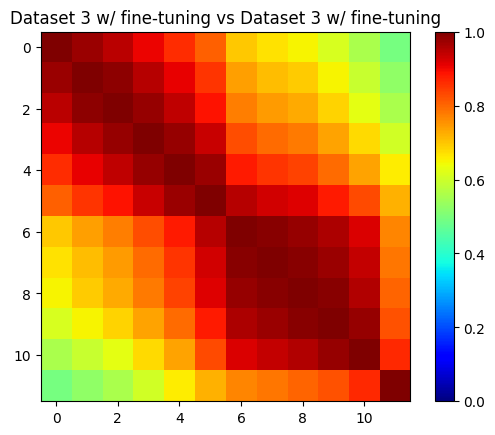

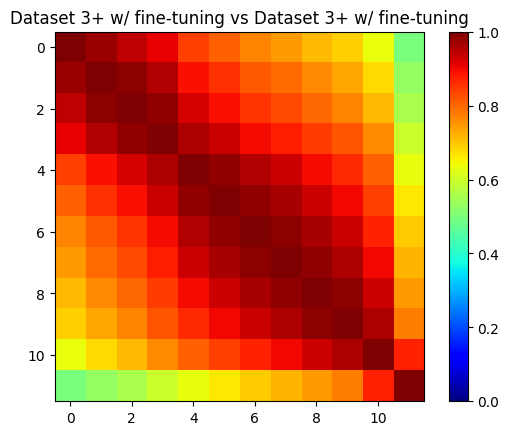

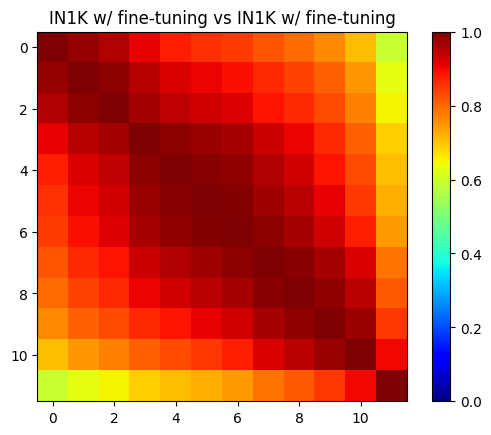

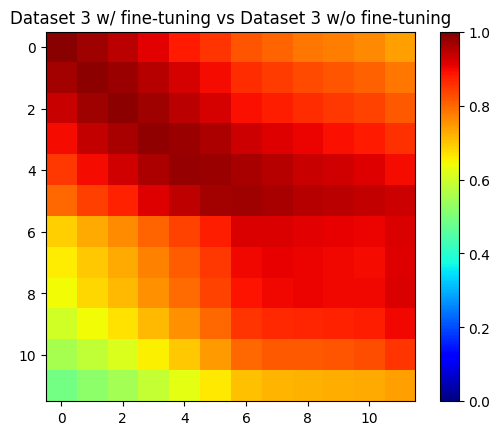

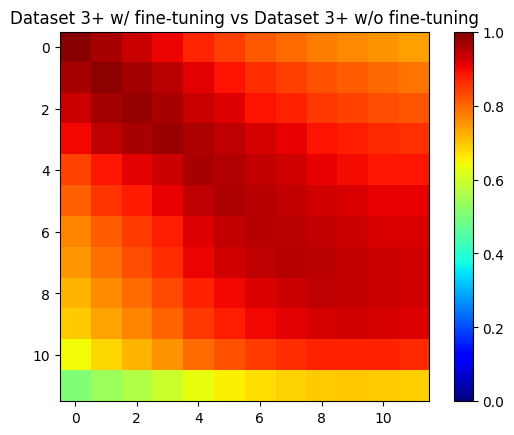

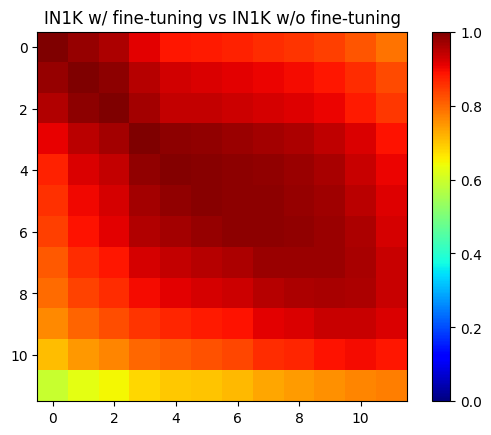

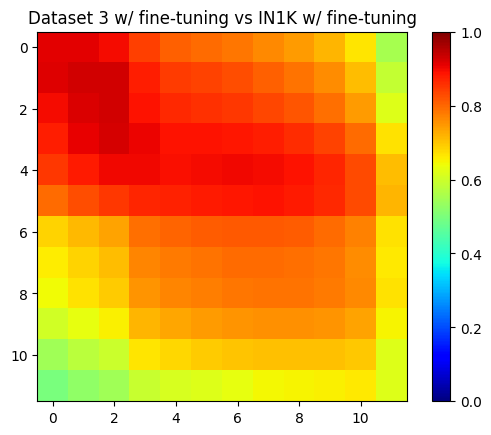

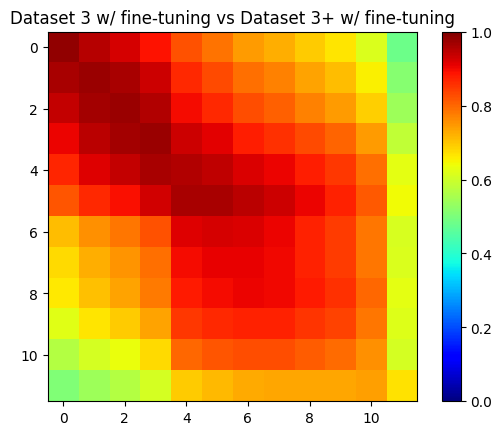

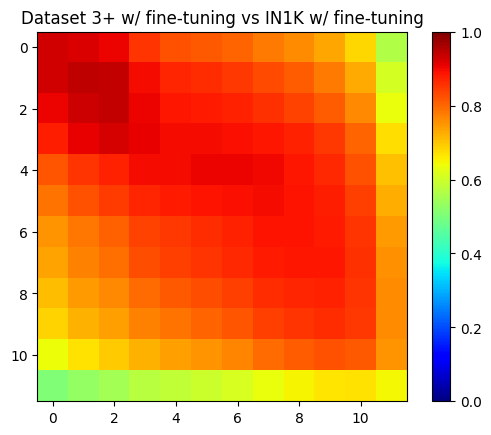

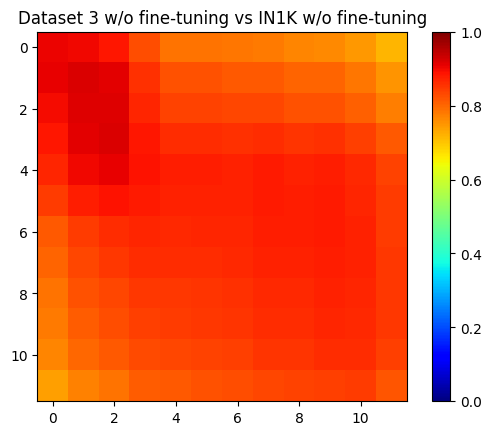

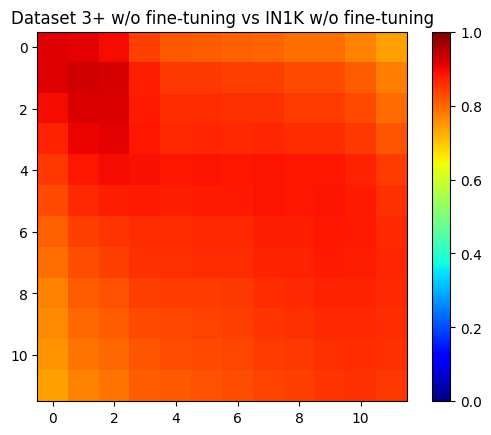

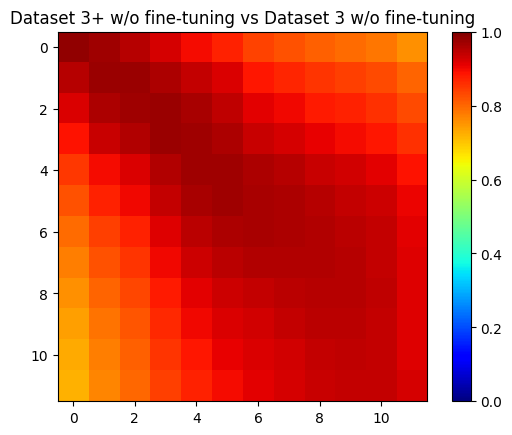

In [41]:
import matplotlib.colors as mcolors



comparions = [['ours w/ fine-tuning vs ours w/o fine-tuning', 1, 2], 
              ['ours w/o fine-tuning vs imagenet w/o fine-tuning', 2, 3],
              ['ours w/ fine-tuning vs imagenet w/ fine-tuning', 1, 0],
              ['ours w/ fine-tuning vs ours w/ fine-tuning', 1, 1],
              ['imagenet w/ fine-tuning vs imagenet w/ fine-tuning', 0, 0]]

comparions = [['ours+ w/ fine-tuning vs ours+ w/o fine-tuning', 1, 2], 
              ['ours+ w/o fine-tuning vs imagenet w/o fine-tuning', 2, 3],
              ['ours+ w/ fine-tuning vs imagenet w/ fine-tuning', 1, 0],
              ['ours+ w/ fine-tuning vs ours+ w/ fine-tuning', 1, 1],
              ['imagenet w/ fine-tuning vs imagenet w/ fine-tuning', 0, 0]]

comparions = [['Dataset 3 w/ fine-tuning vs Dataset 3 w/o fine-tuning', 1, 2], 
              ['Dataset 3 w/o fine-tuning vs IN1K w/o fine-tuning', 2, 3],
              ['Dataset 3 w/ fine-tuning vs IN1K w/ fine-tuning', 1, 0],
              ['Dataset 3 w/ fine-tuning vs Dataset 3 w/ fine-tuning', 1, 1],
              ['IN1K w/ fine-tuning vs IN1K w/ fine-tuning', 0, 0],
              ['Dataset 3+ w/ fine-tuning vs Dataset 3+ w/o fine-tuning', 4, 5], 
              ['Dataset 3+ w/o fine-tuning vs IN1K w/o fine-tuning', 5, 3],
              ['Dataset 3+ w/ fine-tuning vs IN1K w/ fine-tuning', 4, 0],
              ['Dataset 3+ w/ fine-tuning vs Dataset 3+ w/ fine-tuning', 4, 4],
              ['Dataset 3+ w/o fine-tuning vs Dataset 3 w/o fine-tuning', 4, 2]]

comparions = [['Dataset 3 w/ fine-tuning vs Dataset 3 w/ fine-tuning', 1, 1],
              ['Dataset 3+ w/ fine-tuning vs Dataset 3+ w/ fine-tuning', 4, 4],
              ['IN1K w/ fine-tuning vs IN1K w/ fine-tuning', 0, 0],
              
              ['Dataset 3 w/ fine-tuning vs Dataset 3 w/o fine-tuning', 1, 2],
              ['Dataset 3+ w/ fine-tuning vs Dataset 3+ w/o fine-tuning', 4, 5],
              ['IN1K w/ fine-tuning vs IN1K w/o fine-tuning', 0, 3],

              ['Dataset 3 w/ fine-tuning vs IN1K w/ fine-tuning', 1, 0],
              ['Dataset 3 w/ fine-tuning vs Dataset 3+ w/ fine-tuning', 1, 4],
              ['Dataset 3+ w/ fine-tuning vs IN1K w/ fine-tuning', 4, 0],

              ['Dataset 3 w/o fine-tuning vs IN1K w/o fine-tuning', 2, 3],
              ['Dataset 3+ w/o fine-tuning vs IN1K w/o fine-tuning', 5, 3],
              ['Dataset 3+ w/o fine-tuning vs Dataset 3 w/o fine-tuning', 5, 2]]





exps = []
for c in comparions:
    exp = get_cka_map(images_representations[:, c[1]], images_representations[:, c[2]])
    exps.append(exp)
    plt.imshow(exp, cmap='jet', vmin=0, vmax=1)
    # Set the colorbar range
    norm = mcolors.Normalize(vmin=0, vmax=1)
    plt.colorbar(plt.cm.ScalarMappable(norm=norm, cmap='jet'))
    plt.title(c[0])
    plt.show()

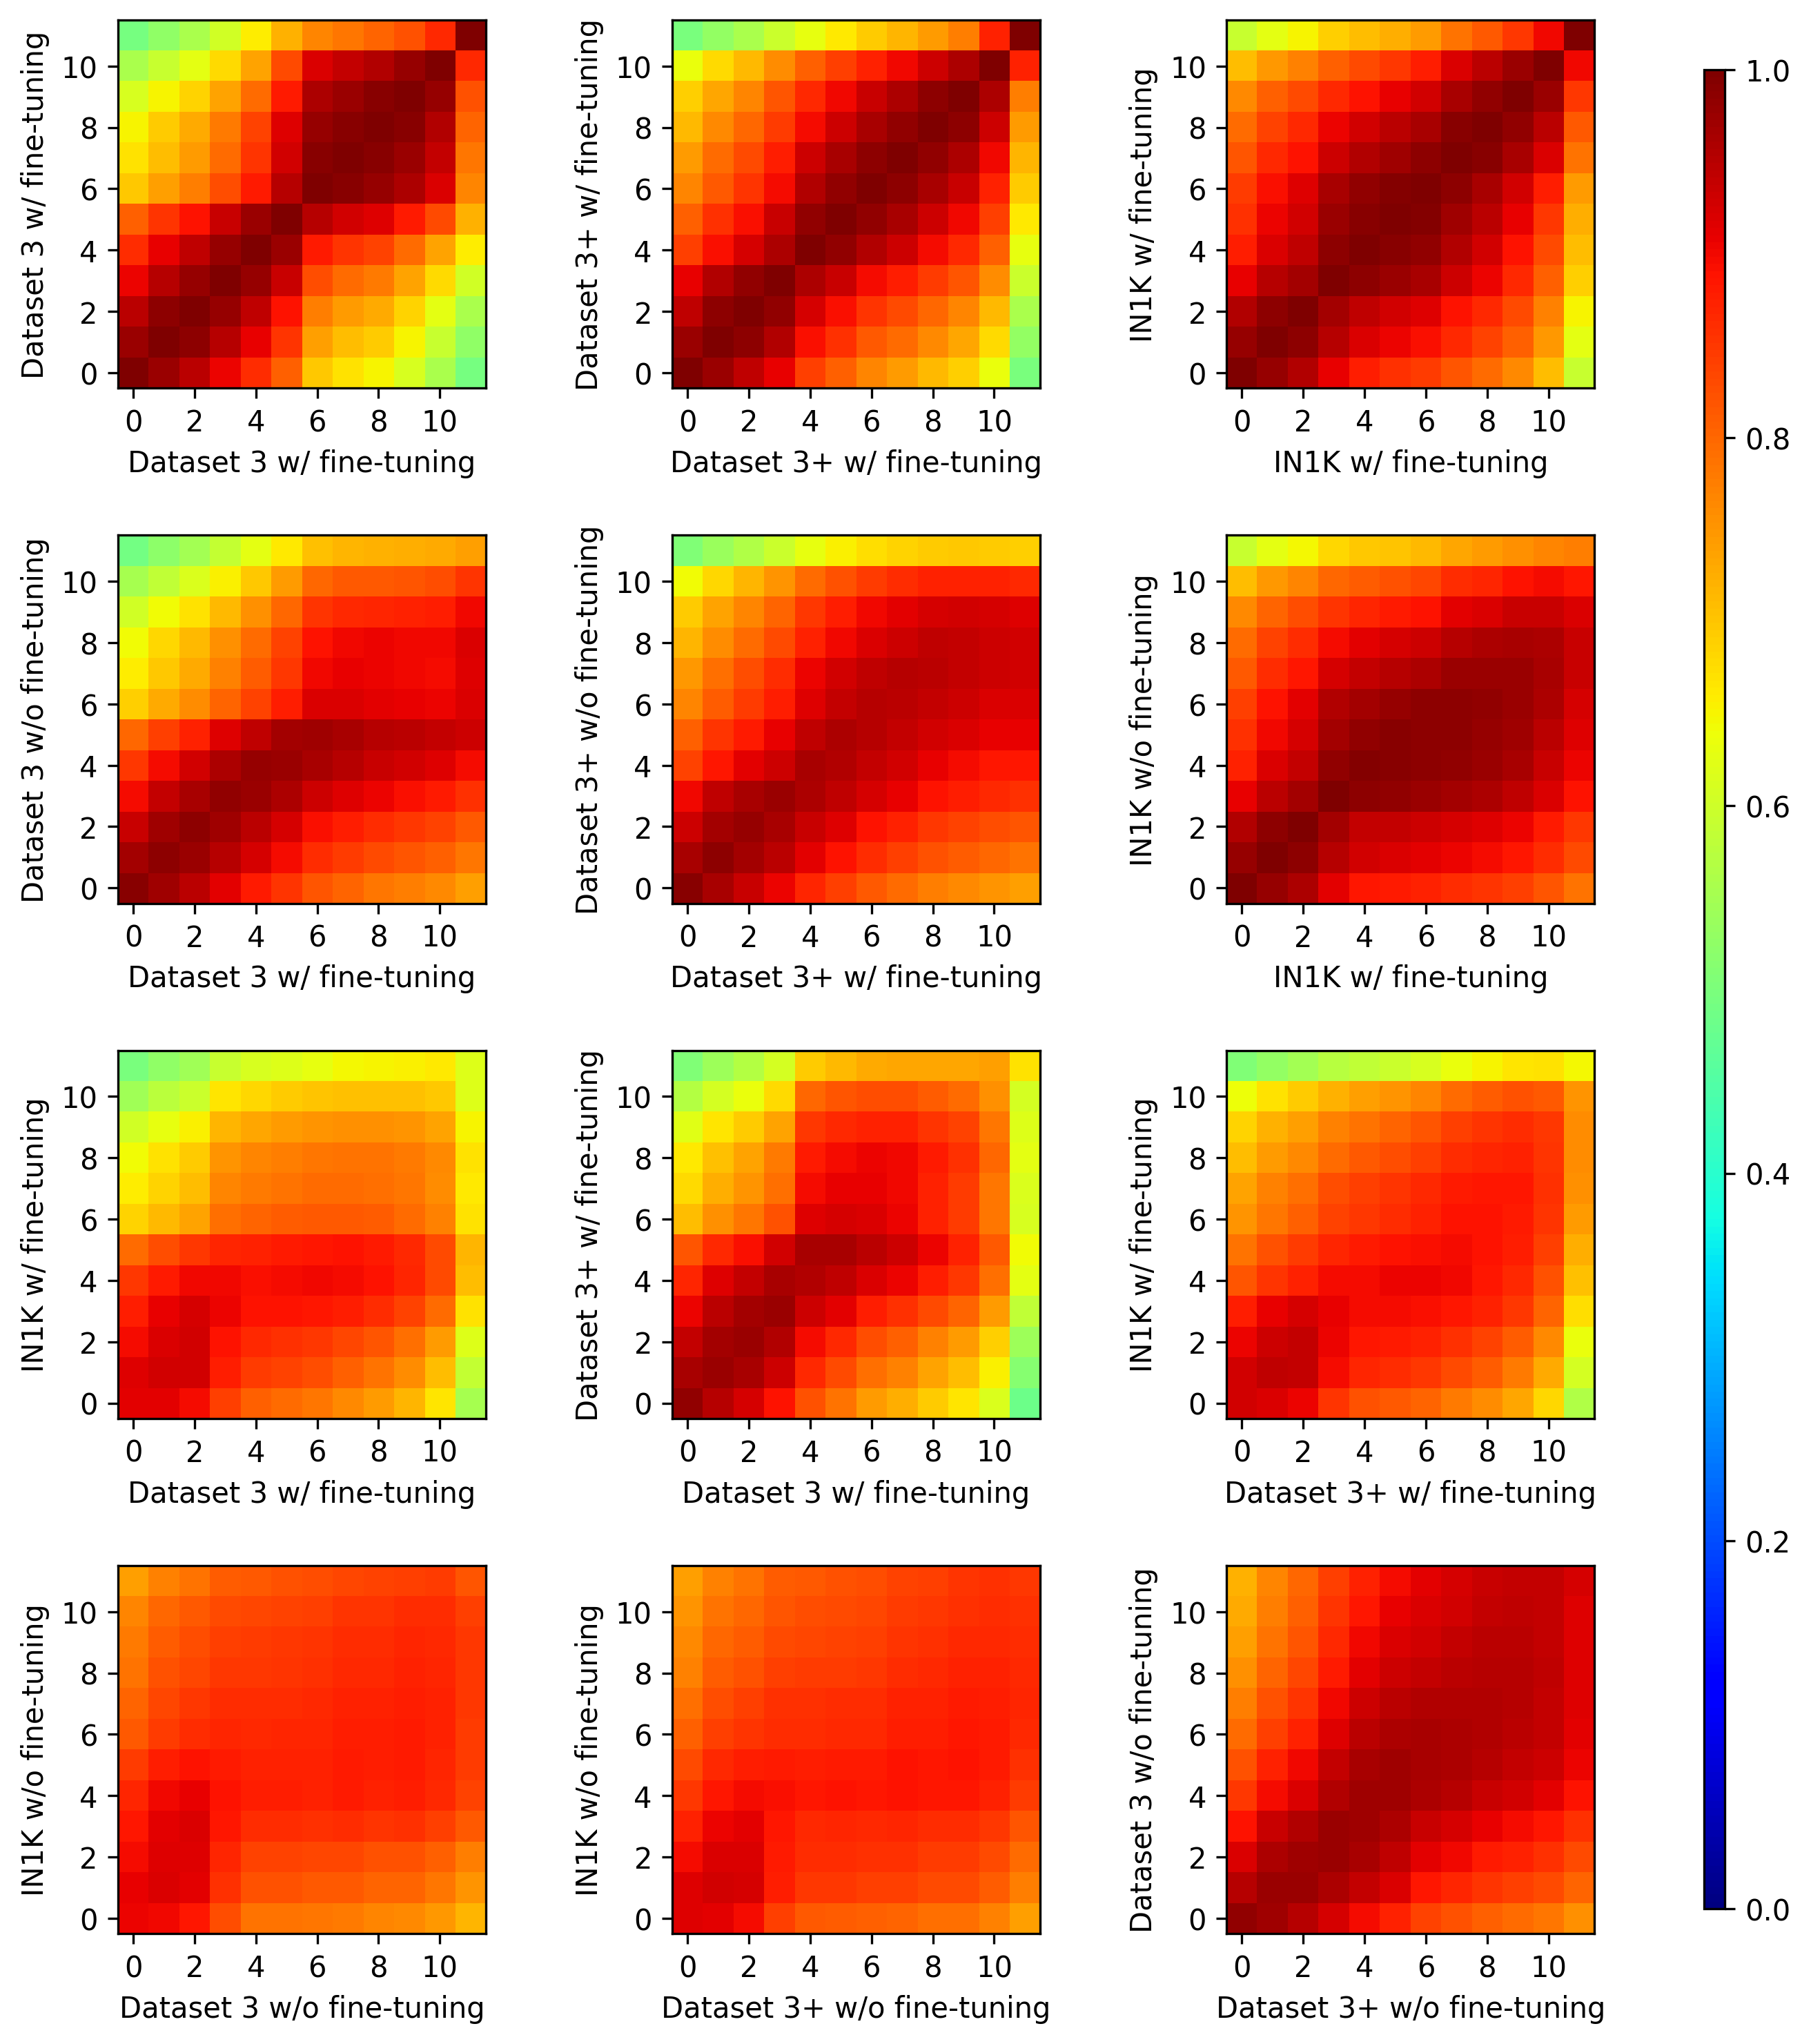

In [42]:
import matplotlib.ticker as mticker
import string
letters = list(string.ascii_lowercase)

exps = np.asarray(exps)

#images_representations = get_images_representations(images, [model_ft_imagenet, model_ft_ours, model_ours, model_imagenet], transform, device, image_size)
titles = ['IN1K w/ fine-tuning', 'Dataset 3 w/ fine-tuning', 'Dataset 3 w/o fine-tuning', 'IN1K w/o fine-tuning', 'Dataset 3+ w/ fine-tuning', 'Dataset 3+ w/o fine-tuning']

lines = 4
base = 3
fig, axs = plt.subplots(lines, int(len(exps)/lines), figsize=(((base)*len(exps)/lines)+(0.35*base), base*lines), dpi=300)
cmap = 'jet'
vmin = 0
vmax = 1

for i, exp in enumerate(exps):
    ax = axs[int(i/(len(exps)/lines)), int(i%(len(exps)/lines))]
    im = ax.imshow(exp, cmap=cmap, vmin=vmin, vmax=vmax)
    ax.invert_yaxis()
    ax.set_xlabel(titles[comparions[i][1]])
    ax.set_ylabel(titles[comparions[i][2]])
    ax.xaxis.set_major_locator(mticker.MultipleLocator(2))
    ax.yaxis.set_major_locator(mticker.MultipleLocator(2))
    ax.set_title(f'({letters[i]})')

# Add a single colorbar
cbar_ax = fig.add_axes([0.92, 0.12, 0.01, 0.74])
fig.colorbar(im, cax=cbar_ax)
fig.subplots_adjust(wspace=0.1, hspace=0.4)
fig.savefig('cka_map.png')
plt.show()

